For the Phosphoros run see `2020-07-02 Chase stars sed`

For the NNPZ run see `2020-07-02 Check NNPZ IB`

In [1]:
%matplotlib inline
from astropy.table import Table, Column, join
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import re
from scikitplot.metrics import plot_confusion_matrix

plt.rcParams['figure.figsize'] = (20, 20)

In [2]:
SPECTRAL_NAMES = np.array(['UNKNOWN', 'O', 'B', 'A', 'F', 'G', 'K', 'M'])
LUMINOSITY_NAMES = np.flip(np.array(['I', 'II', 'III', 'IV', 'V']))

SED_RE = re.compile('uk([rw]?)(\w\d+(\.\d+)?)(\w+)')

def classes_from_sed_name(sed):
    """
    From the sed filename, extract luminosity and spectral class (in this order)
    """
    filename = os.path.basename(sed)
    if filename.endswith('.sed'):
        filename = filename[:-4]
    match = SED_RE.match(filename)
    assert match is not None, sed
    return match.group(4).upper(), match.group(2).upper()

def categorical_idx(data, labels):
    """
    Returns the index of each categorical data entry in labels
    """
    sorter = np.argsort(labels)
    data_idx = sorter[np.searchsorted(labels, data, sorter=sorter)]
    return data_idx

TEMP_TO_SPECTRAL = Table([
    Column(['O', 'B', 'A', 'F', 'G', 'K', 'M'], name='T'),
    Column([30000, 10000, 7500, 6000, 5200, 3700, 0.], name='MIN'),
    Column([np.inf, 30000, 10000, 7500, 6000, 5200, 3700], name='MAX')
])
SED_LIB = Table.read('/home/aalvarez/Work/Data/SC7/TU/Stars/Deep/EUC-TEST-SEDLIB-2013-11-14_MODIF.fits')

def classes_from_tu_seds(template_idx):
    seds = SED_LIB[template_idx]
    spectral = []
    for sed in tqdm(seds):
        match = np.logical_and(TEMP_TO_SPECTRAL['MIN'] < sed['TEFF'], sed['TEFF'] <= TEMP_TO_SPECTRAL['MAX'])
        assert match.sum() == 1
        spectral.append(TEMP_TO_SPECTRAL['T'][match][0])
    return np.array(spectral)

def categorical_hist(ax, data, labels, density=True, **kwargs):
    """
    Plot an histogram of categorical classes following the order given in labels
    """
    sorter = np.argsort(labels)
    data_idx = sorter[np.searchsorted(labels, data, sorter=sorter)]
    ax.hist(data_idx, bins=np.arange(-0.5, len(labels)), density=density)
    ax.set_xticks(np.arange(0, len(labels)))
    ax.set_xticklabels(labels, **kwargs.get('ticks', {}))

In [3]:
ref_table = Table.read('/home/aalvarez/Work/Data/StarsSEDs/Reference.fits')
ref_spectral = []
ref_luminosity = []
for rs in ref_table['SED']:
    lumi, spec = classes_from_sed_name(rs)
    ref_spectral.append(spec[0])
    ref_luminosity.append(lumi)
ref_spectral = categorical_idx(ref_spectral, SPECTRAL_NAMES)
ref_luminosity = categorical_idx(ref_luminosity, LUMINOSITY_NAMES)
ref_table.add_column(Column(ref_spectral, name='SP'))
ref_table.add_column(Column(ref_luminosity, name='LM'))

In [4]:
true_photo = Table.read('/home/aalvarez/Work/Data/StarsSEDs/TargetSynth2.fits', hdu=1)

spectral = classes_from_tu_seds(true_photo['SED_TEMPLATE'])
spectral = categorical_idx(spectral, SPECTRAL_NAMES)
true_photo.add_column(Column(spectral, name='SP'))

In [5]:
uniform = Table.read('/home/aalvarez/Work/Data/StarsSEDs/UniformEBV.fits')
uniform_matched = join(true_photo, uniform, 'ID')

# Sources with all neighbors at the same distance

In [6]:
nw = uniform['NEIGHBOR_WEIGHTS']
all_same_weights = np.sum(np.isclose(nw[:,0:1], nw), axis=1) == 30
len(all_same_weights), all_same_weights.sum()

(5000, 4984)

## Not flagged

In [7]:
mask = uniform['FLAGS_1'] == 0
nw = uniform['NEIGHBOR_WEIGHTS'][mask]
all_same_weights = np.sum(np.isclose(nw[:,0:1], nw), axis=1) == 30
len(all_same_weights), all_same_weights.sum()

(622, 613)

## Not all at the same distance

In [8]:
nw = uniform_matched['NEIGHBOR_WEIGHTS']
mask = np.sum(np.isclose(nw[:,0:1], nw), axis=1) != 30
not_all = uniform_matched[mask]

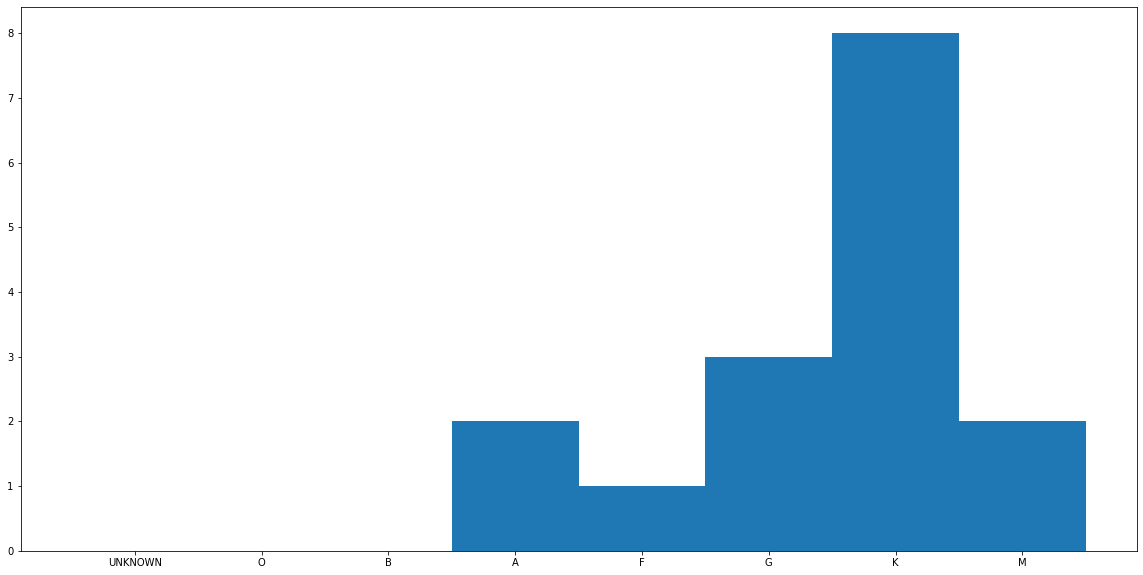

In [9]:
fig, axes = plt.subplots(ncols=1, figsize=(20, 10))
categorical_hist(axes, SPECTRAL_NAMES[not_all['SP']], SPECTRAL_NAMES, density=False)
plt.show()